# How to handle ROICaT outputs

This notebook demonstrates how to handle the outputs of the ROICaT tracking pipeline.

1. **Aligning data**
2. **Quality control**: \
   a. Applying inclusion criteria \
   b. Understanding qualty control metrics 

<br>

You will learn how to use the following utility functions:
- `roicat.util.match_arrays_with_ucids`
- `roicat.util.squeeze_UCID_labels`
- `roicat.util.mask_UCIDs_with_iscell`
- `roicat.util.discard_UCIDs_with_fewer_matches`
- `roicat.util.mask_UCIDs_by_label`

In [2]:
%load_ext autoreload
%autoreload 2
import roicat
import roicat.util

import numpy as np
import matplotlib.pyplot as plt

## 1. Aligning data

The most common usage of ROICaT tracking is to align timeseries data acquired over multiple sessions. After running ROICaT tracking, we are left with outputs we call 'labels' / 'UCIDs' (unique cluster IDs). These are unique integer ID numbers assigned that describe which cluster each ROI corresponds to across all sessions. Non-negative labels describe unique clusters, while '-1' specifically describes unclustered ROIs.

Here we will align timeseries data using these 'labels' / 'UCIDs'. This will be accomplish by reindexing the first (row) dimension of some shape `(n_rois, n_timepoints)` data using the `roicat.util.match_arrays_with_ucids` function.

In [3]:
## Set variables
n_sessions = 3
n_rois = [np.random.randint(low=300, high=500) for _ in range(n_sessions)]  ## Number of ROIs per session ranges from 300 to 500
n_timepoints = 10000
n_rois_no_label = 250  ## Number of ROIs per session that were un-clustered (i.e. ucid = -1)

## Simulate timeseries data from [n_sessions] sessions
data = [np.random.rand(n, n_timepoints) for n in n_rois]  ## [(n_rois, n_timepoints)] * n_sessions

## Simulate ROI labels / ucids
roi_labels = [np.random.choice(a=max(n_rois), size=n, replace=False) for n in n_rois]  ## [(n_rois,)] * n_sessions

### make some of the ROIs have -1 as the label (i.e. not assigned)
for i in range(n_sessions):
    roi_labels[i][np.random.choice(a=n_rois[i], size=n_rois_no_label, replace=False)] = -1  ## set [n_rois_no_label] ROIs to have -1 as the label

## Remove unassigned labels (not necessary, but reduces the number of unique labels)
roi_labels = roicat.util.squeeze_UCID_labels(ucids=roi_labels, return_array=True)  ## [(n_rois,)] * n_sessions

## Align the data
data_aligned = roicat.util.match_arrays_with_ucids(
    arrays=data,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=roi_labels,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
)

## Check the results
print("Number of unique labels total:")
print(len(np.unique(np.concatenate(roi_labels))) - 1)  ## subtract 1 to account for ucids that = -1
print('')
print("Original data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data])
print('')
print("Aligned data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data_aligned])

Number of unique labels total:
317

Original data shapes [(n_rois, n_timepoints)] * n_sessions:
[(483, 10000), (338, 10000), (329, 10000)]

Aligned data shapes [(n_rois, n_timepoints)] * n_sessions:
[(317, 10000), (317, 10000), (317, 10000)]


Observe that the number of rows in the `data_aligned` is now equal to the number of unique labels.

Let's visualize the alignment.

The original timeseries data is of shape `(n_rois, n_timepoints)`, while the aligned timeseries data is of shape `(n_unique_labels, n_timepoints)`.

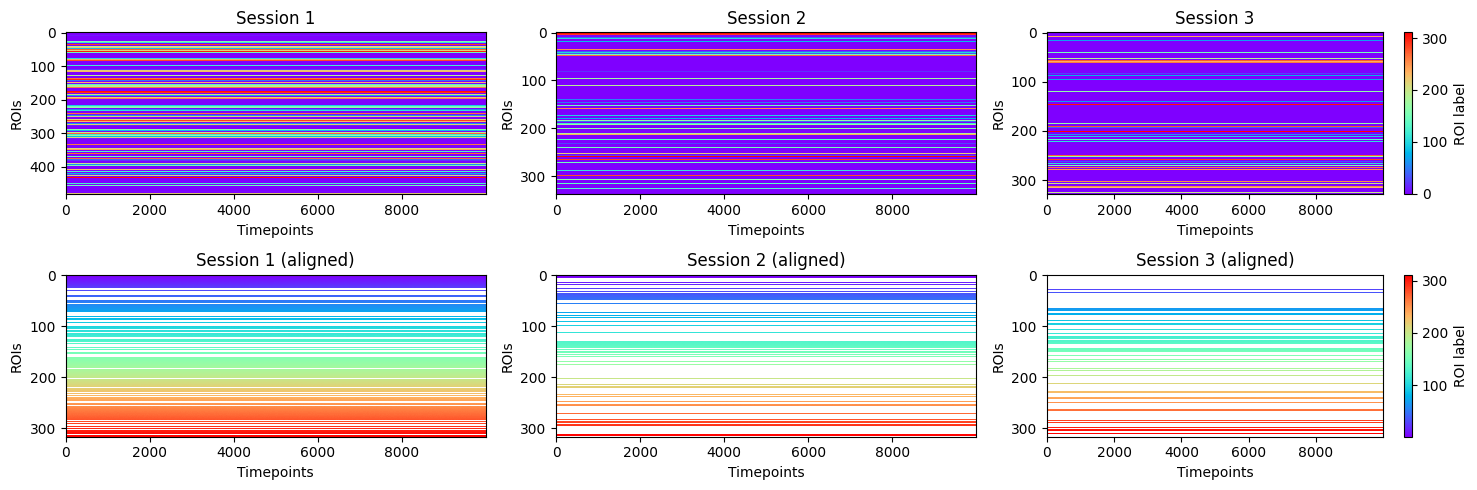

In [4]:
## Make a version of the data where the amplitude of the data scales with the ROI label
data_rainbow = [d + r[:, None] for d, r in zip(data, roi_labels)]
data_rainbow_aligned = roicat.util.match_arrays_with_ucids(
    arrays=data_rainbow,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=roi_labels,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
)

fig, axs = plt.subplots(2, n_sessions, figsize=(15, 5))
for i in range(n_sessions):
    axs[0, i].imshow(data_rainbow[i],         aspect="auto", cmap="rainbow", interpolation="none")
    axs[1, i].imshow(data_rainbow_aligned[i], aspect="auto", cmap="rainbow", interpolation="none")
    axs[0, i].set_title(f"Session {i+1}")
    axs[1, i].set_title(f"Session {i+1} (aligned)")
    axs[0, i].set_xlabel("Timepoints")
    axs[1, i].set_xlabel("Timepoints")
    axs[0, i].set_ylabel("ROIs")
    axs[1, i].set_ylabel("ROIs")
    ## Colorbar
    if i == n_sessions - 1:
        fig.colorbar(axs[0, i].imshow(data_rainbow[i], aspect="auto", cmap="rainbow", interpolation="none"), ax=axs[0, i], label="ROI label")
        fig.colorbar(axs[1, i].imshow(data_rainbow_aligned[i], aspect="auto", cmap="rainbow", interpolation="none"), ax=axs[1, i], label="ROI label")
plt.tight_layout()

We can also look at the what the original indices for the aligned data were by passing the 'return_indices' argument:

In [5]:
## Recover original indices
data_aligned, idx_original_aligned = roicat.util.match_arrays_with_ucids(
    arrays=data,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=roi_labels,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
    return_indices=True,  
)

The values of `idx_original_aligned` represent the old indices in `data`, whereas the indices in `idx_original_aligned` match the indices in `data_aligned`. Note that the dtype of `idx_original_aligned` is a floating point, because some of the elements are NaNs; these elements represent clusters with no corresponding ROI from that session.

`idx_original_aligned` can be used directly to align any data with indices matching the original data. For example, if you have some metadata associated with each ROI, you can align that metadata using `idx_original_aligned` and the `roicat.helpers.index_with_nans` function.

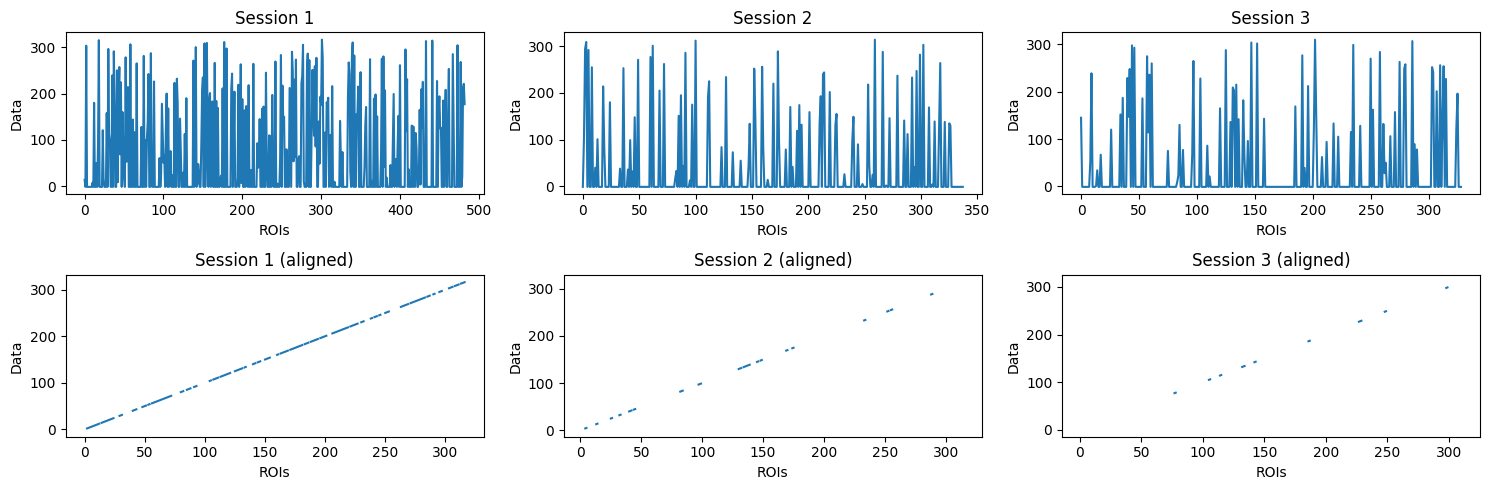

In [6]:
## Align some similar data (like metadata for each ROI) using idx_original_aligned
### Here we'll just use the labels as the new data so that we can see the alignment
data_similar = [l.astype(np.float32) for l in roi_labels]  ## [(n_rois,)] * n_sessions

data_similar_aligned = [roicat.helpers.index_with_nans(values=d, indices=idx) for d, idx in zip(data_similar, idx_original_aligned)]

fig, axs = plt.subplots(2, n_sessions, figsize=(15, 5))
for i in range(n_sessions):
    axs[0, i].plot(data_similar[i])
    axs[1, i].plot(data_similar_aligned[i])
    axs[0, i].set_title(f"Session {i+1}")
    axs[1, i].set_title(f"Session {i+1} (aligned)")
    axs[0, i].set_xlabel("ROIs")
    axs[1, i].set_xlabel("ROIs")
    axs[0, i].set_ylabel("Data")
    axs[1, i].set_ylabel("Data")
plt.tight_layout()

## 2. Quality control

### a. Applying inclusion criteria

##### Example 1: Remove bad ROIs from labels / UCIDs
For example, you may want to remove ROIs that are not cells. This can be done using the `roicat.util.mask_UCIDs_with_iscell` function.

In [7]:
## Make a boolean mask for whether each original ROI is a cell or not
iscell = [np.random.choice(a=[True, False], size=n, p=[0.5, 0.5]) for n in n_rois]  ## [(n_rois,)] * n_sessions

## Apply the mask to the aligned data
labels_iscell = roicat.util.mask_UCIDs_with_iscell(
    ucids=roi_labels,
    iscell=iscell,
)
## Squeeze the labels to remove the unassigned labels (not necessary, but reduces the number of unique labels)
labels_iscell = roicat.util.squeeze_UCID_labels(ucids=labels_iscell, return_array=True)  ## [(n_rois,)] * n_sessions

## Align the data with the masked labels
data_aligned_masked = roicat.util.match_arrays_with_ucids(
    arrays=data,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=labels_iscell,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
)

## Check the results
print("Original data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data])
print('')
print("First aligned data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data_aligned])
print('')
print("iscell masked aligned data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data_aligned_masked])

Original data shapes [(n_rois, n_timepoints)] * n_sessions:
[(483, 10000), (338, 10000), (329, 10000)]

First aligned data shapes [(n_rois, n_timepoints)] * n_sessions:
[(317, 10000), (317, 10000), (317, 10000)]

iscell masked aligned data shapes [(n_rois, n_timepoints)] * n_sessions:
[(198, 10000), (198, 10000), (198, 10000)]


Note that the number of unique labels has decreased because we have removed some ROIs.

##### Example 2: Remove clusters with few ROIs

You may want to only analyze data from clusters with a minimum number of ROIs. This can be done using the `roicat.util.discard_UCIDs_with_fewer_matches` function.

INFO: 1.89% of UCIDs that appear in at least 3 sessions.


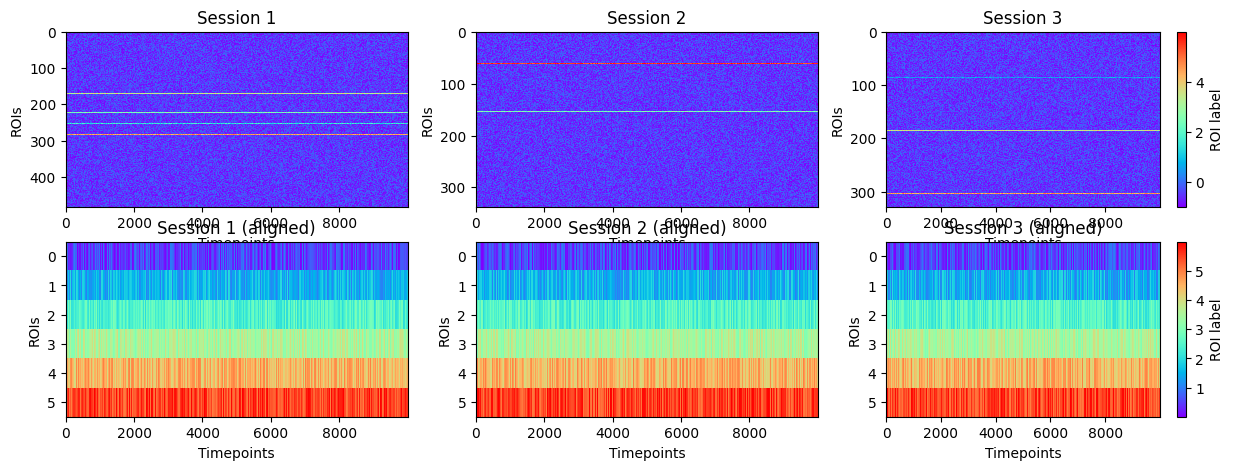

In [8]:
n_sessions_minimum = 3

## Remove labels / UCIDs that are not assigned in at least [n_sessions_minimum] sessions
labels_minSesh = roicat.util.discard_UCIDs_with_fewer_matches(
    ucids=roi_labels,
    n_sesh_thresh=n_sessions_minimum,
)
## Squeeze the labels to remove the unassigned labels (not necessary, but reduces the number of unique labels)
labels_minSesh = roicat.util.squeeze_UCID_labels(ucids=labels_minSesh, return_array=True)  ## [(n_rois,)] * n_sessions

## Align the data with the masked labels
data_aligned_minSesh = roicat.util.match_arrays_with_ucids(
    arrays=data,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=labels_minSesh,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
)

## Visualize the results
data_rainbow_minSesh = [d + r[:, None] for d, r in zip(data, labels_minSesh)]
data_rainbow_aligned_minSesh = roicat.util.match_arrays_with_ucids(
    arrays=data_rainbow_minSesh,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=labels_minSesh,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
)
fig, axs = plt.subplots(2, n_sessions, figsize=(15, 5))
for i in range(n_sessions):
    axs[0, i].imshow(data_rainbow_minSesh[i],         aspect="auto", cmap="rainbow", interpolation="none")
    axs[1, i].imshow(data_rainbow_aligned_minSesh[i], aspect="auto", cmap="rainbow", interpolation="none")
    axs[0, i].set_title(f"Session {i+1}")
    axs[1, i].set_title(f"Session {i+1} (aligned)")
    axs[0, i].set_xlabel("Timepoints")
    axs[1, i].set_xlabel("Timepoints")
    axs[0, i].set_ylabel("ROIs")
    axs[1, i].set_ylabel("ROIs")
    ## Colorbar
    if i == n_sessions - 1:
        fig.colorbar(axs[0, i].imshow(data_rainbow_minSesh[i], aspect="auto", cmap="rainbow", interpolation="none"), ax=axs[0, i], label="ROI label")
        fig.colorbar(axs[1, i].imshow(data_rainbow_aligned_minSesh[i], aspect="auto", cmap="rainbow", interpolation="none"), ax=axs[1, i], label="ROI label")

Note that the number of unique labels has decreased significantly because we have removed clusters with fewer thatn `n_sessions_minimum` ROIs. Also note that there are fewer rows that are NaNs in the final aligned data, this is because there are fewer labels that = -1 (unclustered ROIs).

##### Example 3: Masking labels / UCIDs by label

You may want to remove specific clusters from the labels / UCIDs. This can be done using the `roicat.util.mask_UCIDs_by_label` function. This is useful for when some clusters are of low quality.

In [9]:
## Define bad cluster labels to remove
labels_keep = np.random.choice(a=np.unique(np.concatenate(roi_labels)), size=80, replace=False)  ## Randomly select 80 labels to keep

## Remove bad cluster labels
labels_masked_keep = roicat.util.mask_UCIDs_by_label(
    ucids=roi_labels,
    labels=labels_keep,
)
## Squeeze the labels to remove the unassigned labels (not necessary, but reduces the number of unique labels)
labels_masked_keep = roicat.util.squeeze_UCID_labels(ucids=labels_masked_keep, return_array=True)  ## [(n_rois,)] * n_sessions

## Align the data with the masked labels
data_aligned_masked_keep = roicat.util.match_arrays_with_ucids(
    arrays=data,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois, n_timepoints))
    ucids=labels_masked_keep,  ## expects list (length n_sessions) of numpy arrays (shape (n_rois,))  OR   concatenated numpy array (shape (n_rois_total,))
)

## Check the results
print("Original data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data])
print('')
print("First aligned data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data_aligned])
print('')
print("labels_masked_keep aligned data shapes [(n_rois, n_timepoints)] * n_sessions:")
print([d.shape for d in data_aligned_masked_keep])

Original data shapes [(n_rois, n_timepoints)] * n_sessions:
[(483, 10000), (338, 10000), (329, 10000)]

First aligned data shapes [(n_rois, n_timepoints)] * n_sessions:
[(317, 10000), (317, 10000), (317, 10000)]

labels_masked_keep aligned data shapes [(n_rois, n_timepoints)] * n_sessions:
[(80, 10000), (80, 10000), (80, 10000)]


### b. Quality control metrics

ROICaT tracking provides a number of quality control metrics that can be used to assess the quality of the tracking. These metrics are stored within the `results_clusters.json` file.

In [57]:
results_clusters = roicat.helpers.json_load(filepath="/media/rich/bigSSD/data_tmp/test_data/mouse_1.tracking.results_clusters.json")

print("Items in the results_clusters dictionary:")
[print(f"'{k}'".ljust(25), f"length: {len(v) if hasattr(v, '__len__') else 'N/A'}") for k, v in results_clusters.items()];

print('')

print("Items in the results_clusters['quality_metrics'] dictionary:")
[print(f"'{k}'".ljust(25), f"length: {len(v) if hasattr(v, '__len__') else 'N/A'}") for k, v in results_clusters['quality_metrics'].items()];

Items in the results_clusters dictionary:
'labels'                  length: 7337
'labels_bySession'        length: 3
'labels_dict'             length: 2143
'quality_metrics'         length: 8

Items in the results_clusters['quality_metrics'] dictionary:
'cluster_labels_unique'   length: 2143
'cluster_intra_means'     length: 2143
'cluster_intra_mins'      length: 2143
'cluster_intra_maxs'      length: 2143
'cluster_silhouette'      length: 2143
'sample_silhouette'       length: 7337
'hdbscan'                 length: N/A
'sequentialHungarian'     length: 4


See the [ROICaT documentation](https://roicat.readthedocs.io/en/latest/inputsAndOutputs.html#quality-control) on what each metric means. Set your own thresholds using these metrics and apply inclusion criteria as shown above.

The `'cluster_...'` metrics have length equal to the number of unique labels. These metrics can be used to filter out bad clusters. The `'sample_...'` metrics have length equal to the total number of ROIs across all sessions. These metrics can be used to filter out bad ROIs.